In [1]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


2024-06-13 09:01:35.769079: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 09:01:35.769201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 09:01:35.891484: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Define the input shape and number of classes

In [2]:
input_shape = (224, 224, 3)
num_classes = 15

# Define data generators with additional data augmentation

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [4]:
# Set batch size
batch_size = 32

# Define train and test generators
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/birds-15/BIRDS_V2/Train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/birds-15/BIRDS_V2/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 23702 images belonging to 15 classes.
Found 6402 images belonging to 15 classes.


# Load MobileNetV2 as base model

In [5]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Freeze layers in base model

In [6]:
for layer in base_model.layers:
    layer.trainable = False

# Add custom head

In [7]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [8]:
# Combine base model and custom head
model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tune the model by unfreezing some layers
for layer in base_model.layers[:-10]:
    layer.trainable = True

# Implement learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)


# Compile the model with class weights

In [9]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Print model summary

In [10]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,585,103 (13.68 MB)

 Trainable params: 2,818,511 (10.75 MB)

 Non-trainable params: 766,592 (2.92 MB)

In [11]:
# Implement early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model with modified settings
history = model.fit(
    train_generator,
    epochs=15,  # Increase epochs for better training
    validation_data=test_generator,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/741 ━━━━━━━━━━━━━━━━━━━━ 12:19:47 60s/step - accuracy: 0.0938 - loss: 3.9026

I0000 00:00:1718269391.641694     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 17/741 ━━━━━━━━━━━━━━━━━━━━ 6:15 519ms/step - accuracy: 0.0978 - loss: 3.4475

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


741/741 ━━━━━━━━━━━━━━━━━━━━ 554s 668ms/step - accuracy: 0.5475 - loss: 1.5137 - val_accuracy: 0.9067 - val_loss: 0.3253
Epoch 2/15
741/741 ━━━━━━━━━━━━━━━━━━━━ 317s 423ms/step - accuracy: 0.9284 - loss: 0.2311 - val_accuracy: 0.9364 - val_loss: 0.2342
Epoch 3/15
741/741 ━━━━━━━━━━━━━━━━━━━━ 318s 425ms/step - accuracy: 0.9613 - loss: 0.1241 - val_accuracy: 0.9592 - val_loss: 0.1696
Epoch 4/15
741/741 ━━━━━━━━━━━━━━━━━━━━ 317s 424ms/step - accuracy: 0.9679 - loss: 0.1004 - val_accuracy: 0.9677 - val_loss: 0.1597
Epoch 5/15
741/741 ━━━━━━━━━━━━━━━━━━━━ 315s 422ms/step - accuracy: 0.9763 - loss: 0.0762 - val_accuracy: 0.9617 - val_loss: 0.1840
Epoch 6/15
741/741 ━━━━━━━━━━━━━━━━━━━━ 315s 422ms/step - accuracy: 0.9806 - loss: 0.0619 - val_accuracy: 0.9655 - val_loss: 0.1821
Epoch 7/15
741/741 ━━━━━━━━━━━━━━━━━━━━ 320s 428ms/step - accuracy: 0.9839 - loss: 0.0524 - val_accuracy: 0.9691 - val_loss: 0.1670


# Evaluate the model on test data

In [12]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

201/201 ━━━━━━━━━━━━━━━━━━━━ 28s 139ms/step - accuracy: 0.9420 - loss: 0.3315
Test Loss: 0.1596904844045639
Test Accuracy: 0.9676663279533386


Found 278 images belonging to 15 classes.
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 512ms/step


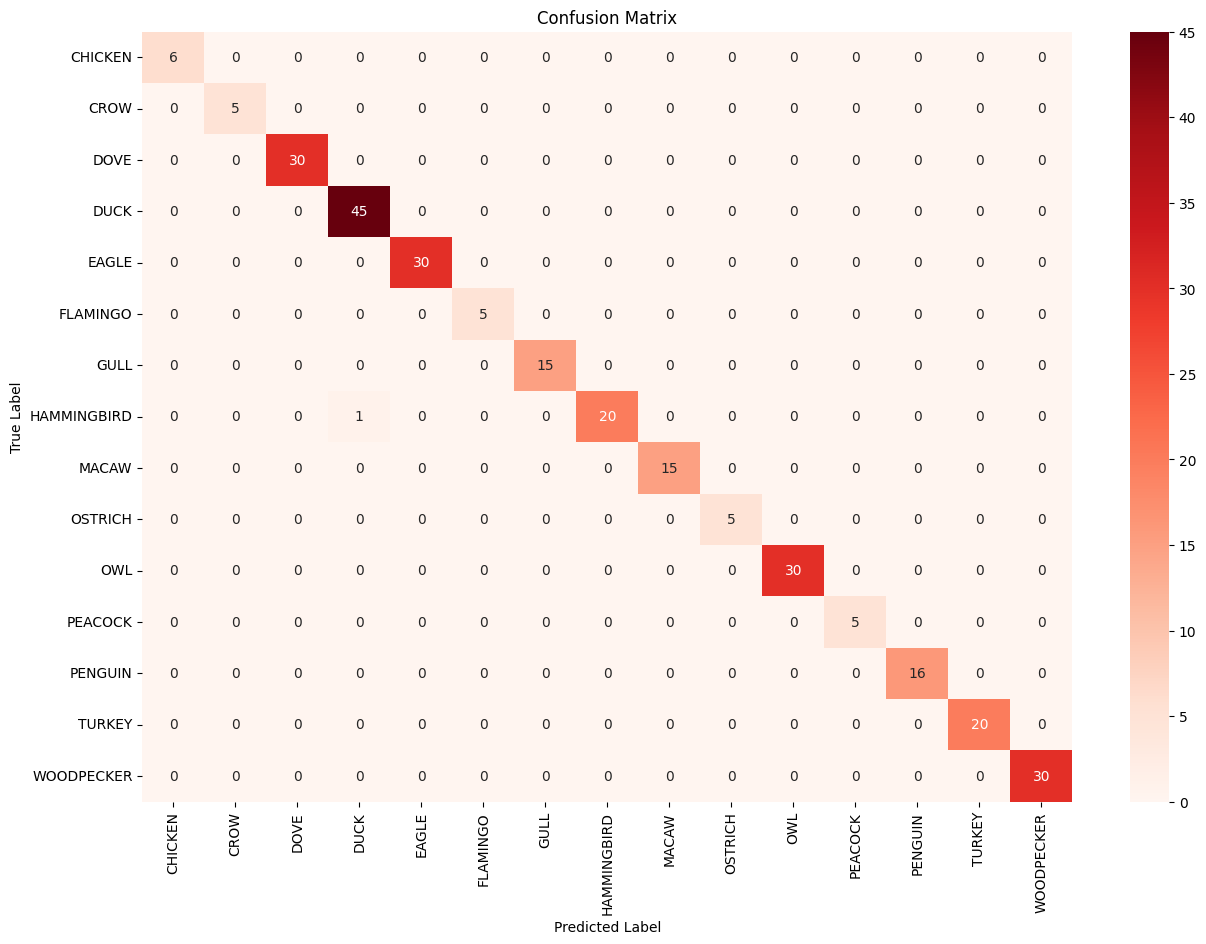

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
# Define the path to the validation directory
validation_dir = '/kaggle/input/valid-birds/validation'

# Define the data generators
validation_datagen = ImageDataGenerator(rescale=1./255)

# Load the validation data using the ImageDataGenerator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the number of classes
num_classes = len(validation_generator.class_indices)

# Define the class labels
class_labels = list(validation_generator.class_indices.keys())

# Make predictions on the validation data
validation_predictions = model.predict(validation_generator)
predicted_labels_validation = np.argmax(validation_predictions, axis=1)

# Get the true labels for the validation data
true_labels_validation = validation_generator.classes

# Calculate confusion matrix for validation data
conf_matrix_validation = confusion_matrix(true_labels_validation, predicted_labels_validation)

# Plot the confusion matrix
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix_validation, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()


# Plot confusion matrix

# Save the model

In [15]:
model.save('birds_best_classes.h5')

In [16]:
from IPython.display import FileLink
FileLink(r'birds_best_classes.h5')

/kaggle/working/birds_best_classes.h5